In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from pyepo.model.grb import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Restricted license - for non-production use only - expires 2024-10-28
Obj: 57.6036
0 -> 5 -> 8 -> 10 -> 4 -> 12 -> 1 -> 17 -> 3 -> 16 -> 9 -> 18 -> 7 -> 2 -> 11 -> 13 -> 19 -> 6 -> 14 -> 15 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 108.08it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 174.07it/s]


In [6]:
# get training and test data set without feat & costs
dataset_train = optDatasetConstrs(optmodel, dataset_train.sols, sols=dataset_train.sols) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, dataset_test.sols, costs=c_test) # without binding constr

Obtaining constraints for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 154.33it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.02it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_node*(num_node-1)//2, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot(range(0, num_epochs+1, log_step), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
    plt.xticks(range(0, num_epochs+1, log_step), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.title("Learning Curve on Test Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
def train(reg, ca_cos, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = ca_cos(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log.append(regret)
            print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log

### Sampling Method

In [11]:
# init model
reg = LinearRegression()

In [12]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [13]:
lr = 1e-2
num_epochs = 20
log_step = 2
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.8281, Regret: 17.0299%
Epoch   2, Loss:  -0.8285, Regret:  1.2653%
Epoch   4, Loss:  -0.8378, Regret:  0.1589%
Epoch   6, Loss:  -0.8545, Regret:  0.0065%
Epoch   8, Loss:  -0.8392, Regret:  0.0000%
Epoch  10, Loss:  -0.8505, Regret:  0.0000%
Epoch  12, Loss:  -0.8493, Regret:  0.0000%
Epoch  14, Loss:  -0.8400, Regret:  0.0000%
Epoch  16, Loss:  -0.8633, Regret:  0.0000%
Epoch  18, Loss:  -0.8500, Regret:  0.0000%
Elapsed Time: 12.74 Sec


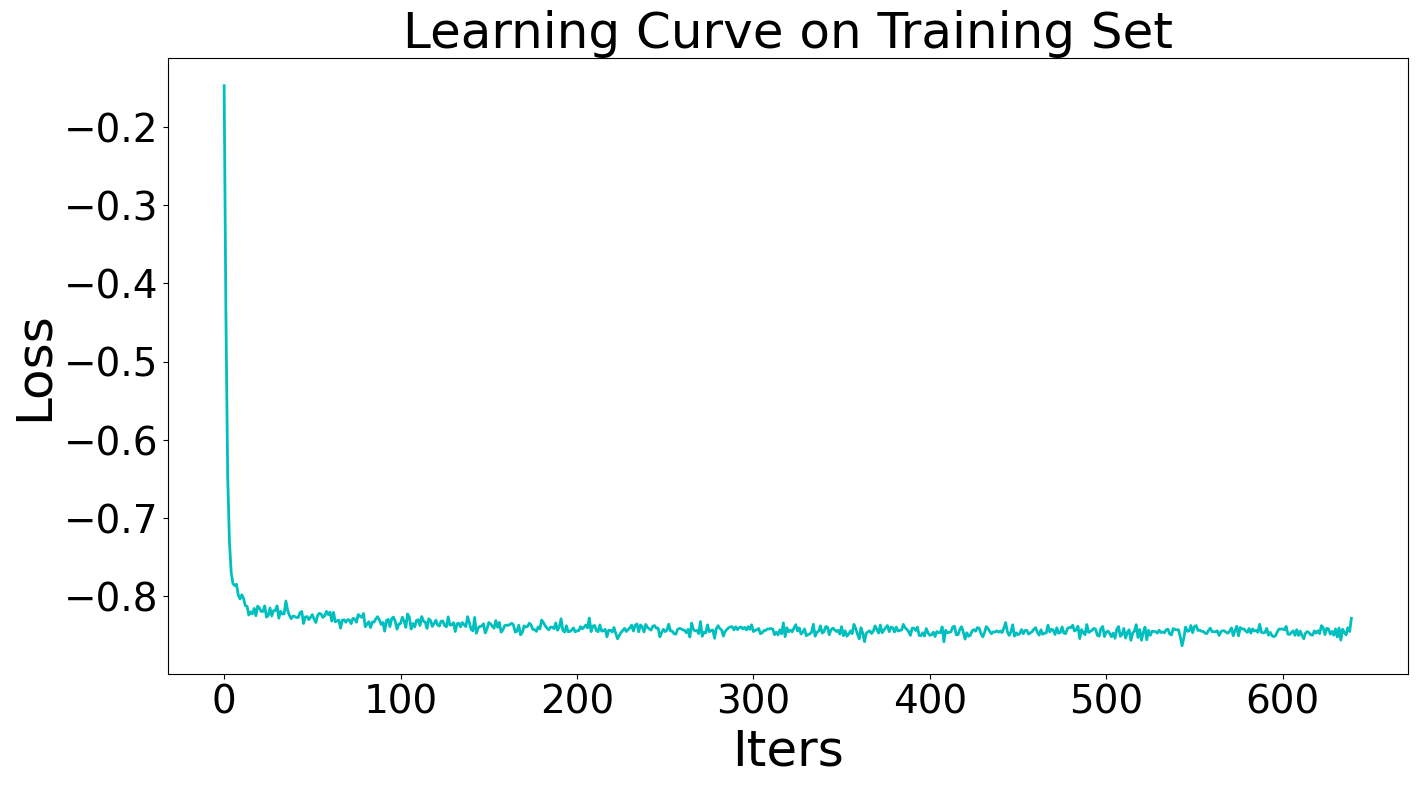

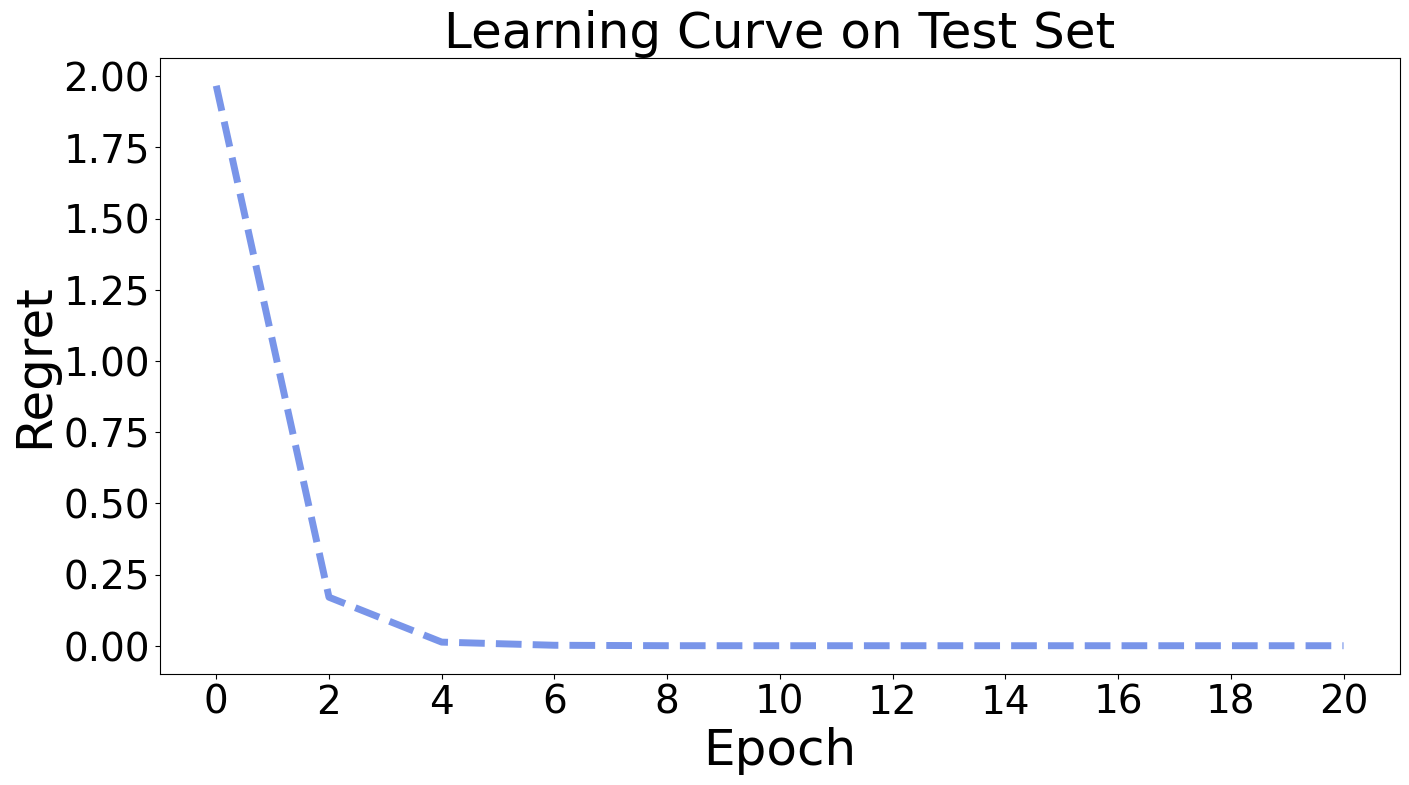

In [14]:
plot(loss_log, regret_log, num_epochs, log_step)

### PFYL  

In [15]:
# init model
reg = LinearRegression()

In [16]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0)

Num of cores: 1


In [17]:
lr = 1e-2
num_epochs = 20
log_step = 2
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# init log
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  21.7500, Regret: 18.5143%
Epoch   2, Loss:  10.0000, Regret:  3.7751%
Epoch   4, Loss:   8.7500, Regret:  1.5108%
Epoch   6, Loss:   5.7500, Regret:  0.8594%
Epoch   8, Loss:   1.5000, Regret:  0.6072%
Epoch  10, Loss:   0.5000, Regret:  0.5600%
Epoch  12, Loss:   1.7500, Regret:  0.4390%
Epoch  14, Loss:   0.5000, Regret:  0.4255%
Epoch  16, Loss:   0.0000, Regret:  0.3064%
Epoch  18, Loss:   0.5000, Regret:  0.3352%
Elapsed Time: 126.92 Sec


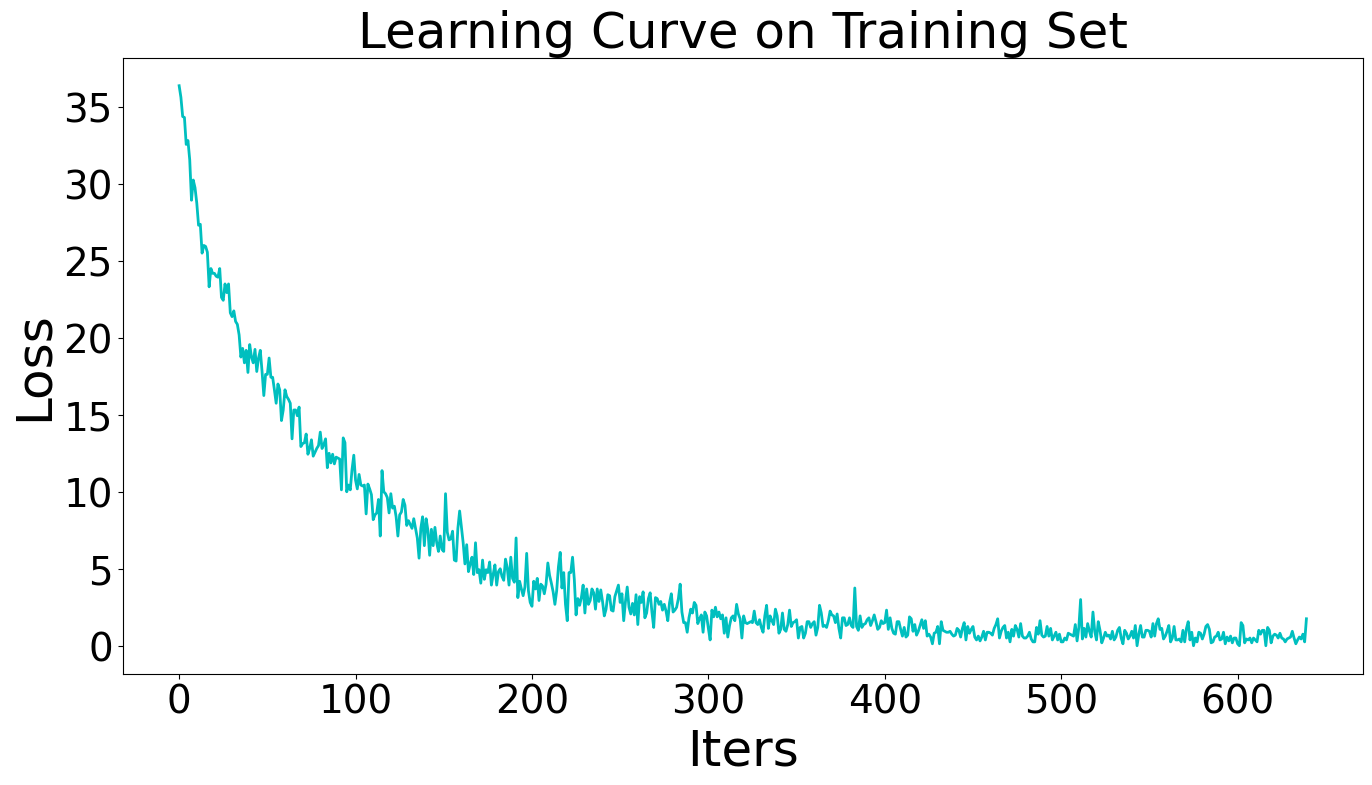

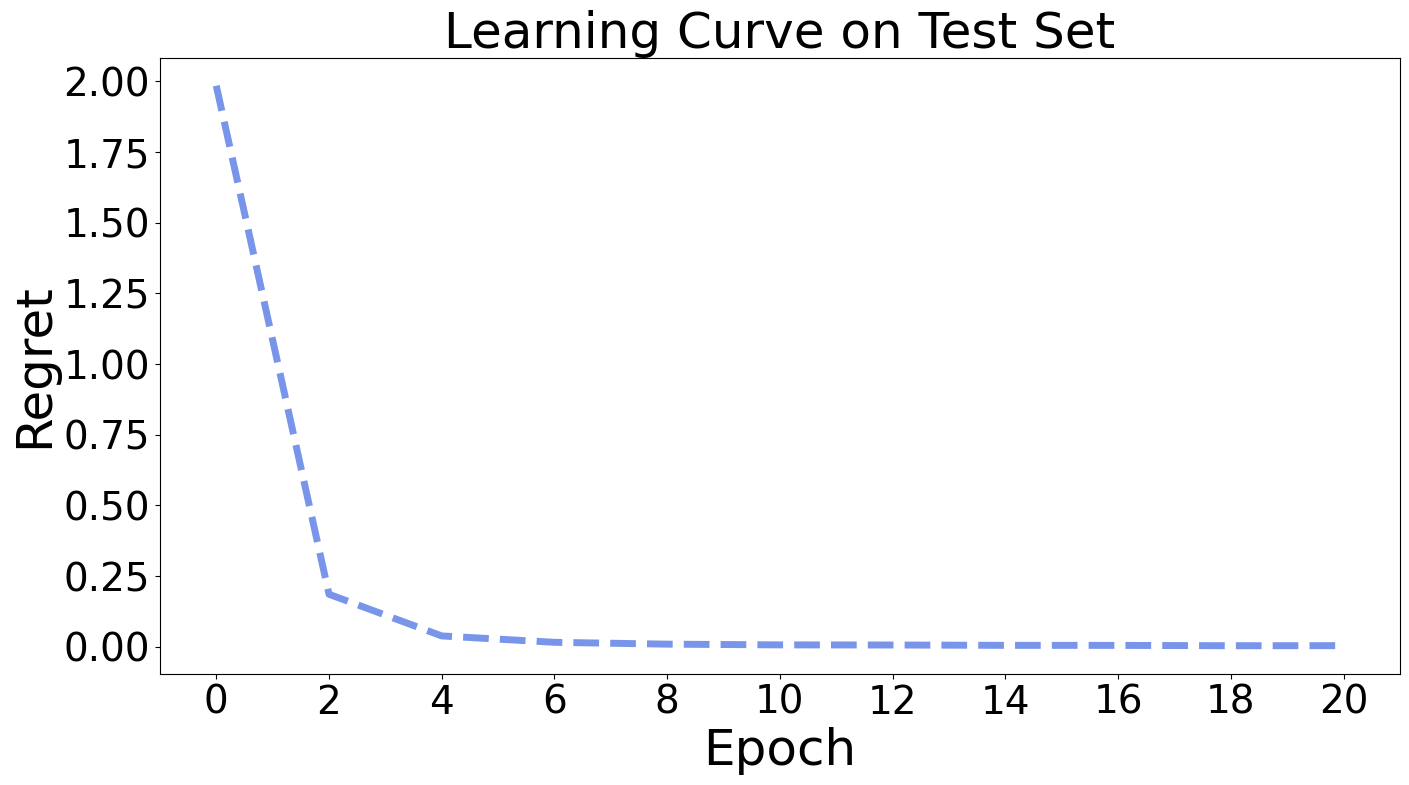

In [18]:
plot(loss_log, regret_log, num_epochs, log_step)